In [6]:
from train_denoiser import img_to_numpy
from test_denoiser import test_acc
from custom_dataset import get_dataloader
from models.denoisers import DnCNN, REDNet20
from utils import create_resnet
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#l2 attack eps
l2_eps = [0.5, 1.0, 2.0, 3.5]
#linf attack eps
linf_eps = [x/256 for x in [2, 5, 10, 16]]

#dncnn denoiser
mnist_dncnn_denoiser = DnCNN(in_channels=3, out_channels=3, depth=7, hidden_channels=64, use_bias=False).to(device)
mnist_dncnn_denoiser.load_state_dict(torch.load('./trained_denoisers/dncnn_mnist_mixed.pth', map_location=device))
cifar10_dncnn_denoiser = DnCNN(in_channels=3, out_channels=3, depth=7, hidden_channels=64, use_bias=False).to(device)
cifar10_dncnn_denoiser.load_state_dict(torch.load('./trained_denoisers/dncnn_cifar10_mixed.pth', map_location=device))
#dae denoiser
mnist_dae_denoiser = REDNet20(in_channels=3, out_channels=3, use_bias=False).to(device)
mnist_dae_denoiser.load_state_dict(torch.load('./trained_denoisers/dae_mnist_mixed.pth', map_location=device))
cifar10_dae_denoiser = REDNet20(in_channels=3, out_channels=3, use_bias=False).to(device)
cifar10_dae_denoiser.load_state_dict(torch.load('./trained_denoisers/dae_cifar10_mixed.pth', map_location=device))

#vanilla resnet model
#mnist
mnist_resnet = create_resnet(device=device, grayscale=True)
mnist_resnet.load_state_dict(torch.load('./trained_models/mnist/resnet18_2.0+0_BL.pth', map_location=device))
#cifar10
cifar10_resnet = create_resnet(device=device, grayscale=False)
cifar10_resnet.load_state_dict(torch.load('./trained_models/cifar10/resnet18_2.0+0_BL_junbo.pth', map_location=device))

#dataset loader
_, mnist_test_loader = get_dataloader(dataset='mnist', batch_size=32, sample_test=True)
_, cifar10_test_loader = get_dataloader(dataset='cifar10', batch_size=32, sample_test=True)
print(len(mnist_test_loader.dataset))

Files already downloaded and verified
Files already downloaded and verified
1024


In [15]:
import pickle
import os

def run_test(test_loader, net, denoiser, denoiser2, attack_mode, eps_range, norm):
    result = {}
    # cw
    if attack_mode == 'cw':
        acc_orig, acc_adv, acc_denoised, acc_denoised2 = test_acc(net, denoiser, test_loader, attack_mode, norm, eps=0.0, show=False, denoiser2=denoiser2)
        result['adv'] = [acc_adv]
        result['dn1'] = [acc_denoised]
        result['dn2'] = [acc_denoised2]
        return result
        
    # fgsm/pgd
    acc1 = []
    acc2 = []
    acc3 = []
    for eps in eps_range:
        print("eps = ", eps)
        acc_orig, acc_adv, acc_denoised, acc_denoised2 = test_acc(net, denoiser, test_loader, attack_mode, norm, eps, show=False, denoiser2=denoiser2)
        acc1.append(acc_adv)
        acc2.append(acc_denoised)
        acc3.append(acc_denoised2)

    result['adv'] = acc1
    result['dn1'] = acc2
    result['dn2'] = acc3
    return result

def plot_result(result, attack, norm, eps_range, dataset, savefig=False, denoised2=True):

    adv, dn1, dn2 = unpack_dict(result)
    plt.figure(figsize=(5,5))
    plt.plot(eps_range, adv, marker='o', label="No Denoiser")
    plt.plot(eps_range, dn1, marker='o', label="DnCNN Denoised")
    if denoised2: plt.plot(eps_range, dn2, marker='o', label="AutoEncoder Denoised")
    plt.title(f"l-{norm} {attack} attack on {dataset}")
    plt.legend(loc="upper right")
    plt.xlabel('epsilon')
    plt.ylabel('model accuracy')
    if savefig:
        if not os.path.exists('denosier_attack_figures'): os.mkdir('denosier_attack_figures')
        fig_name = f"mnist_{attack}_l{norm}.png"
        plt.savefig(os.path.join('denosier_attack_figures', fig_name), dpi=500)

    plt.show()
    

def save_result(filename, result, root='denoiser_attack_results', overwrite=False):
    if not os.path.exists(root): os.mkdir(root)

    file_path = os.path.join(root, filename)
    if os.path.exists(file_path) and (not overwrite):
        print("Updating pickle file")
        prev_result = load_result(file_path)
        prev_result.update(result)
        result = prev_result
        # # update result if current result is better
        # adv, prev_dn1, prev_dn2 = unpack_dict(prev_result)
        # adv, prev_dn1, prev_dn2 = np.array(adv), np.array(prev_dn1), np.array(prev_dn2)
        # _, dn1, dn2 = unpack_dict(result)
        
    with open(file_path, 'wb') as f:
        pickle.dump(result, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_result(file_path):
    if not os.path.exists(file_path):
        raise ValueError("Results file not found.")
    
    with open(file_path, "rb") as f:
        result = pickle.load(f)
    
    return result

def unpack_dict(result_dict):
    adv = result_dict['adv']
    dn1 = result_dict['dn1']
    dn2 = result_dict['dn2']
    return adv, dn1, dn2


Evaluating fgsm attack on l2 norm ...
eps =  0.5


100%|██████████| 32/32 [00:01<00:00, 17.16it/s]


Test Accuracy no attack: 0.990234375
Test Accuracy with fgsm attack: 0.9755859375
Test Accuracy with fgsm attack + denoiser1: 0.9912109375
Test Accuracy with fgsm attack + denoiser2: 0.98828125
eps =  1.0


100%|██████████| 32/32 [00:01<00:00, 20.61it/s]


Test Accuracy no attack: 0.990234375
Test Accuracy with fgsm attack: 0.953125
Test Accuracy with fgsm attack + denoiser1: 0.9833984375
Test Accuracy with fgsm attack + denoiser2: 0.984375
eps =  2.0


100%|██████████| 32/32 [00:01<00:00, 20.83it/s]


Test Accuracy no attack: 0.990234375
Test Accuracy with fgsm attack: 0.8720703125
Test Accuracy with fgsm attack + denoiser1: 0.974609375
Test Accuracy with fgsm attack + denoiser2: 0.9599609375
eps =  3.5


100%|██████████| 32/32 [00:01<00:00, 20.68it/s]


Test Accuracy no attack: 0.990234375
Test Accuracy with fgsm attack: 0.763671875
Test Accuracy with fgsm attack + denoiser1: 0.916015625
Test Accuracy with fgsm attack + denoiser2: 0.888671875

Evaluating fgsm attack on linf norm ...
eps =  0.0078125


100%|██████████| 32/32 [00:01<00:00, 20.88it/s]


Test Accuracy no attack: 0.990234375
Test Accuracy with fgsm attack: 0.98828125
Test Accuracy with fgsm attack + denoiser1: 0.990234375
Test Accuracy with fgsm attack + denoiser2: 0.9892578125
eps =  0.01953125


100%|██████████| 32/32 [00:01<00:00, 21.11it/s]


Test Accuracy no attack: 0.990234375
Test Accuracy with fgsm attack: 0.9775390625
Test Accuracy with fgsm attack + denoiser1: 0.990234375
Test Accuracy with fgsm attack + denoiser2: 0.990234375
eps =  0.0390625


100%|██████████| 32/32 [00:01<00:00, 21.02it/s]


Test Accuracy no attack: 0.990234375
Test Accuracy with fgsm attack: 0.9580078125
Test Accuracy with fgsm attack + denoiser1: 0.9873046875
Test Accuracy with fgsm attack + denoiser2: 0.98828125
eps =  0.0625


100%|██████████| 32/32 [00:01<00:00, 21.23it/s]


Test Accuracy no attack: 0.990234375
Test Accuracy with fgsm attack: 0.9296875
Test Accuracy with fgsm attack + denoiser1: 0.9873046875
Test Accuracy with fgsm attack + denoiser2: 0.984375

Evaluating pgd attack on l2 norm ...
eps =  0.5


100%|██████████| 32/32 [00:20<00:00,  1.57it/s]


Test Accuracy no attack: 0.990234375
Test Accuracy with pgd attack: 0.990234375
Test Accuracy with pgd attack + denoiser1: 0.990234375
Test Accuracy with pgd attack + denoiser2: 0.990234375
eps =  1.0


100%|██████████| 32/32 [00:19<00:00,  1.61it/s]


Test Accuracy no attack: 0.990234375
Test Accuracy with pgd attack: 0.9892578125
Test Accuracy with pgd attack + denoiser1: 0.990234375
Test Accuracy with pgd attack + denoiser2: 0.9873046875
eps =  2.0


100%|██████████| 32/32 [00:20<00:00,  1.56it/s]


Test Accuracy no attack: 0.990234375
Test Accuracy with pgd attack: 0.9892578125
Test Accuracy with pgd attack + denoiser1: 0.990234375
Test Accuracy with pgd attack + denoiser2: 0.9892578125
eps =  3.5


100%|██████████| 32/32 [00:20<00:00,  1.57it/s]


Test Accuracy no attack: 0.990234375
Test Accuracy with pgd attack: 0.9892578125
Test Accuracy with pgd attack + denoiser1: 0.9912109375
Test Accuracy with pgd attack + denoiser2: 0.990234375

Evaluating pgd attack on linf norm ...
eps =  0.0078125


100%|██████████| 32/32 [00:19<00:00,  1.67it/s]


Test Accuracy no attack: 0.990234375
Test Accuracy with pgd attack: 0.98828125
Test Accuracy with pgd attack + denoiser1: 0.990234375
Test Accuracy with pgd attack + denoiser2: 0.9892578125
eps =  0.01953125


100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


Test Accuracy no attack: 0.990234375
Test Accuracy with pgd attack: 0.9775390625
Test Accuracy with pgd attack + denoiser1: 0.990234375
Test Accuracy with pgd attack + denoiser2: 0.990234375
eps =  0.0390625


100%|██████████| 32/32 [00:18<00:00,  1.69it/s]


Test Accuracy no attack: 0.990234375
Test Accuracy with pgd attack: 0.974609375
Test Accuracy with pgd attack + denoiser1: 0.990234375
Test Accuracy with pgd attack + denoiser2: 0.9921875
eps =  0.0625


100%|██████████| 32/32 [00:19<00:00,  1.67it/s]


Test Accuracy no attack: 0.990234375
Test Accuracy with pgd attack: 0.970703125
Test Accuracy with pgd attack + denoiser1: 0.98828125
Test Accuracy with pgd attack + denoiser2: 0.98828125

Evaluating C&W attack ...


100%|██████████| 32/32 [06:24<00:00, 12.00s/it]


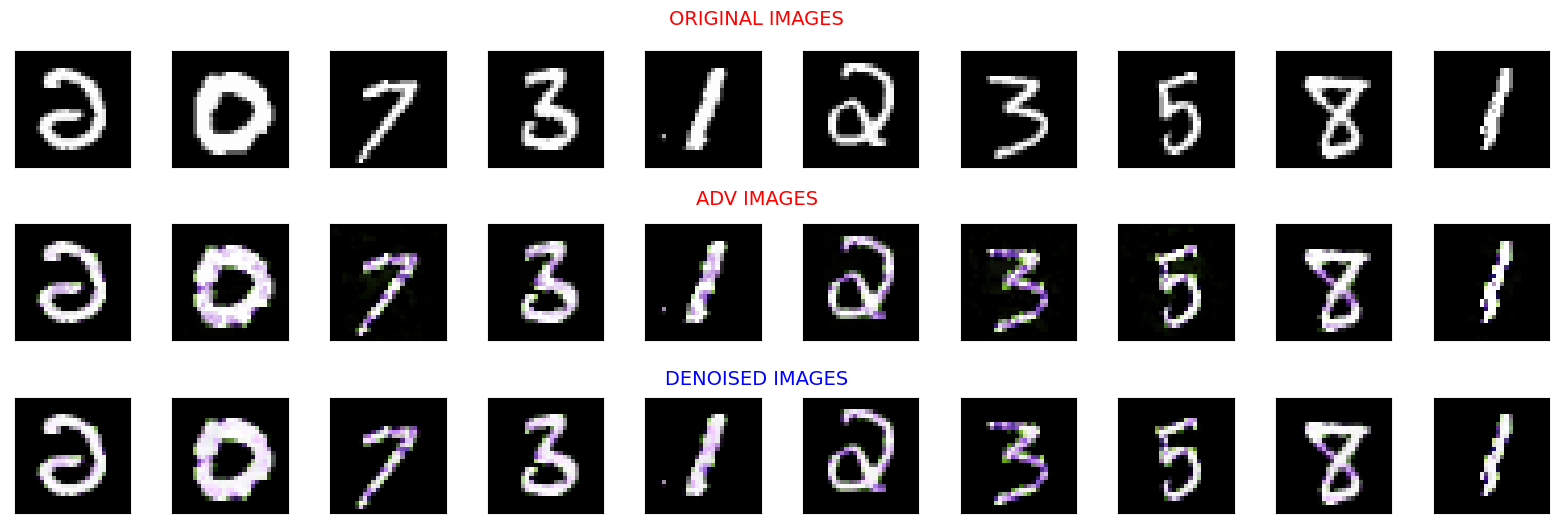

Test Accuracy no attack: 0.990234375
Test Accuracy with cw attack: 0.0625
Test Accuracy with cw attack + denoiser1: 0.984375
Test Accuracy with cw attack + denoiser2: 0.982421875

Evaluating fgsm attack on l2 norm ...
eps =  0.5


100%|██████████| 32/32 [00:01<00:00, 21.09it/s]


Test Accuracy no attack: 0.828125
Test Accuracy with fgsm attack: 0.314453125
Test Accuracy with fgsm attack + denoiser1: 0.5966796875
Test Accuracy with fgsm attack + denoiser2: 0.4404296875
eps =  1.0


100%|██████████| 32/32 [00:01<00:00, 20.28it/s]


Test Accuracy no attack: 0.828125
Test Accuracy with fgsm attack: 0.2392578125
Test Accuracy with fgsm attack + denoiser1: 0.37109375
Test Accuracy with fgsm attack + denoiser2: 0.2802734375
eps =  2.0


100%|██████████| 32/32 [00:01<00:00, 22.15it/s]


Test Accuracy no attack: 0.828125
Test Accuracy with fgsm attack: 0.1982421875
Test Accuracy with fgsm attack + denoiser1: 0.2373046875
Test Accuracy with fgsm attack + denoiser2: 0.2109375
eps =  3.5


100%|██████████| 32/32 [00:01<00:00, 22.11it/s]


Test Accuracy no attack: 0.828125
Test Accuracy with fgsm attack: 0.1796875
Test Accuracy with fgsm attack + denoiser1: 0.201171875
Test Accuracy with fgsm attack + denoiser2: 0.203125

Evaluating fgsm attack on linf norm ...
eps =  0.0078125


100%|██████████| 32/32 [00:01<00:00, 22.80it/s]


Test Accuracy no attack: 0.828125
Test Accuracy with fgsm attack: 0.3994140625
Test Accuracy with fgsm attack + denoiser1: 0.697265625
Test Accuracy with fgsm attack + denoiser2: 0.552734375
eps =  0.01953125


100%|██████████| 32/32 [00:01<00:00, 21.91it/s]


Test Accuracy no attack: 0.828125
Test Accuracy with fgsm attack: 0.2119140625
Test Accuracy with fgsm attack + denoiser1: 0.5263671875
Test Accuracy with fgsm attack + denoiser2: 0.2861328125
eps =  0.0390625


100%|██████████| 32/32 [00:01<00:00, 19.89it/s]


Test Accuracy no attack: 0.828125
Test Accuracy with fgsm attack: 0.1630859375
Test Accuracy with fgsm attack + denoiser1: 0.2705078125
Test Accuracy with fgsm attack + denoiser2: 0.17578125
eps =  0.0625


100%|██████████| 32/32 [00:01<00:00, 22.13it/s]


Test Accuracy no attack: 0.828125
Test Accuracy with fgsm attack: 0.1376953125
Test Accuracy with fgsm attack + denoiser1: 0.158203125
Test Accuracy with fgsm attack + denoiser2: 0.1435546875

Evaluating pgd attack on l2 norm ...
eps =  0.5


100%|██████████| 32/32 [00:19<00:00,  1.68it/s]


Test Accuracy no attack: 0.828125
Test Accuracy with pgd attack: 0.8076171875
Test Accuracy with pgd attack + denoiser1: 0.794921875
Test Accuracy with pgd attack + denoiser2: 0.806640625
eps =  1.0


100%|██████████| 32/32 [00:19<00:00,  1.63it/s]


Test Accuracy no attack: 0.828125
Test Accuracy with pgd attack: 0.80078125
Test Accuracy with pgd attack + denoiser1: 0.8037109375
Test Accuracy with pgd attack + denoiser2: 0.8056640625
eps =  2.0


100%|██████████| 32/32 [00:19<00:00,  1.66it/s]


Test Accuracy no attack: 0.828125
Test Accuracy with pgd attack: 0.763671875
Test Accuracy with pgd attack + denoiser1: 0.802734375
Test Accuracy with pgd attack + denoiser2: 0.7998046875
eps =  3.5


100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


Test Accuracy no attack: 0.828125
Test Accuracy with pgd attack: 0.6748046875
Test Accuracy with pgd attack + denoiser1: 0.7841796875
Test Accuracy with pgd attack + denoiser2: 0.759765625

Evaluating pgd attack on linf norm ...
eps =  0.0078125


100%|██████████| 32/32 [00:18<00:00,  1.70it/s]


Test Accuracy no attack: 0.828125
Test Accuracy with pgd attack: 0.2314453125
Test Accuracy with pgd attack + denoiser1: 0.689453125
Test Accuracy with pgd attack + denoiser2: 0.4931640625
eps =  0.01953125


100%|██████████| 32/32 [00:18<00:00,  1.76it/s]


Test Accuracy no attack: 0.828125
Test Accuracy with pgd attack: 0.1259765625
Test Accuracy with pgd attack + denoiser1: 0.52734375
Test Accuracy with pgd attack + denoiser2: 0.2802734375
eps =  0.0390625


100%|██████████| 32/32 [00:18<00:00,  1.75it/s]


Test Accuracy no attack: 0.828125
Test Accuracy with pgd attack: 0.0986328125
Test Accuracy with pgd attack + denoiser1: 0.396484375
Test Accuracy with pgd attack + denoiser2: 0.2119140625
eps =  0.0625


100%|██████████| 32/32 [00:18<00:00,  1.75it/s]


Test Accuracy no attack: 0.828125
Test Accuracy with pgd attack: 0.0947265625
Test Accuracy with pgd attack + denoiser1: 0.3017578125
Test Accuracy with pgd attack + denoiser2: 0.1923828125

Evaluating C&W attack ...


100%|██████████| 32/32 [06:07<00:00, 11.49s/it]


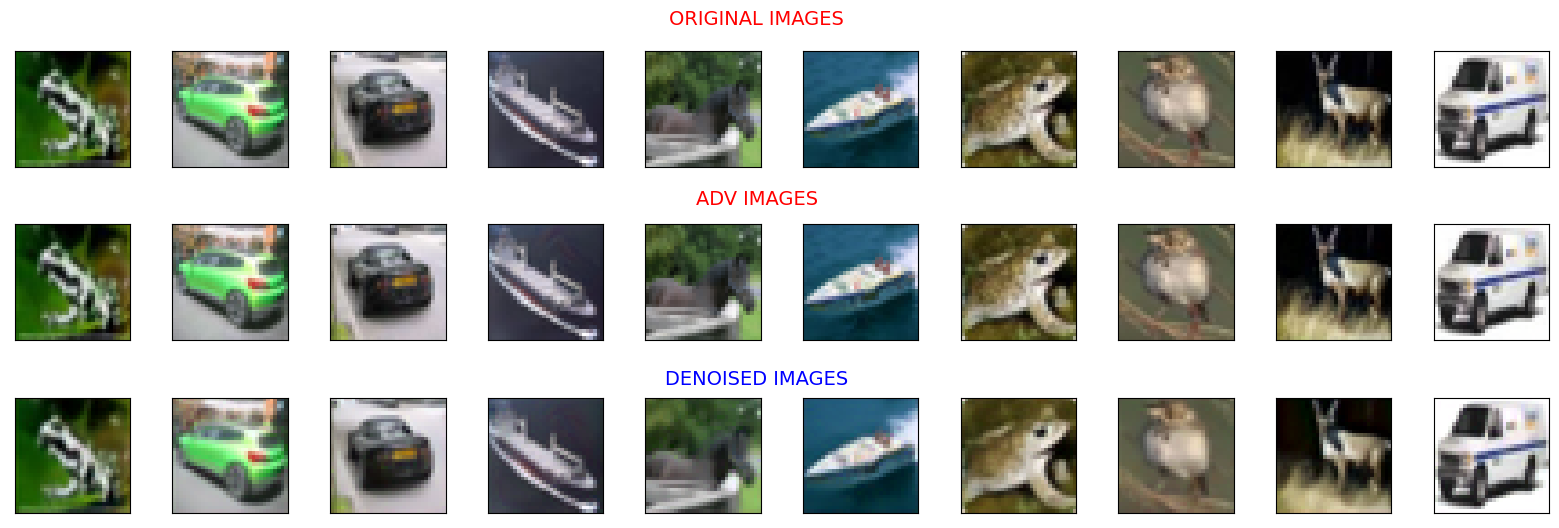

Test Accuracy no attack: 0.828125
Test Accuracy with cw attack: 0.099609375
Test Accuracy with cw attack + denoiser1: 0.78125
Test Accuracy with cw attack + denoiser2: 0.7802734375


In [8]:
# run mnist
for attack in ['fgsm', 'pgd', 'cw']:
    if attack == 'cw':
        print(f"\nEvaluating C&W attack ...")
        file_name = f"mnist_{attack}.pkl"
        result = run_test(mnist_test_loader, mnist_resnet, mnist_dncnn_denoiser, mnist_dae_denoiser, attack, [0.0], norm=1)
        save_result(file_name, result, overwrite=True)
        continue

    for norm in ['2', 'inf']:
        print(f"\nEvaluating {attack} attack on l{norm} norm ...")
        file_name = f"mnist_{attack}_l{norm}.pkl"
        # convert norm
        if norm == '2':
            eps_range = l2_eps
            norm = int(norm)
        else:
            eps_range = linf_eps
            norm = np.inf
        
        result = run_test(mnist_test_loader, mnist_resnet, mnist_dncnn_denoiser, mnist_dae_denoiser, attack, eps_range, norm=norm)
        save_result(file_name, result, overwrite=True)


# run cifar10
for attack in ['fgsm', 'pgd', 'cw']:
    if attack == 'cw':
        print(f"\nEvaluating C&W attack ...")
        file_name = f"cifar10_{attack}.pkl"
        result = run_test(cifar10_test_loader, cifar10_resnet, cifar10_dncnn_denoiser, cifar10_dae_denoiser, attack, [0.0], norm=1)
        save_result(file_name, result, overwrite=True)
        continue

    for norm in ['2', 'inf']:
        print(f"\nEvaluating {attack} attack on l{norm} norm ...")
        file_name = f"cifar10_{attack}_l{norm}.pkl"
        # convert norm
        if norm == '2':
            eps_range = l2_eps
            norm = int(norm)
        else:
            eps_range = linf_eps
            norm = np.inf
        
        result = run_test(cifar10_test_loader, cifar10_resnet, cifar10_dncnn_denoiser, cifar10_dae_denoiser, attack, eps_range, norm=norm)
        save_result(file_name, result, overwrite=True)
    

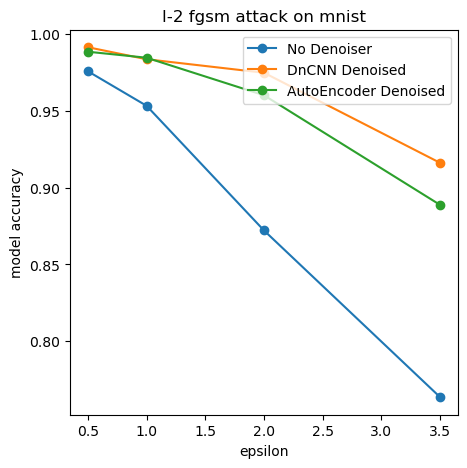

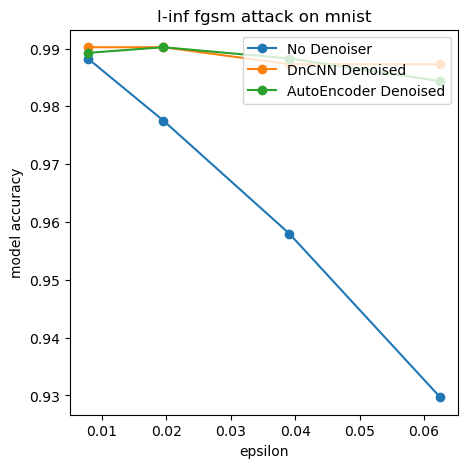

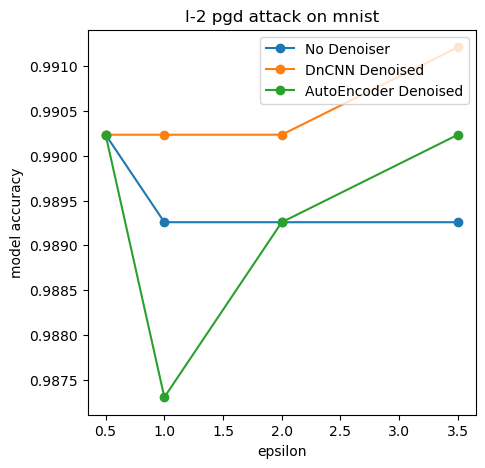

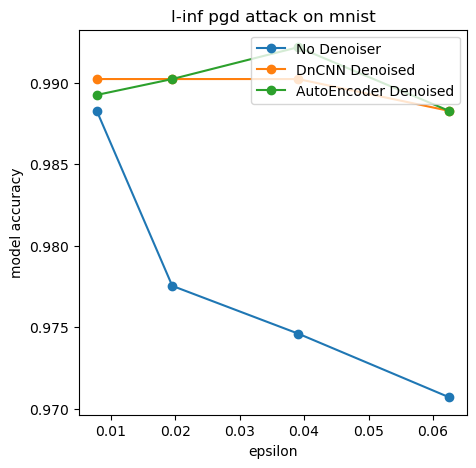

In [16]:
#plot mnist
for attack in ['fgsm', 'pgd']:
    for norm in ['2', 'inf']:
        #print(f"\nEvaluating {attack} attack on l{norm} norm ...")
        file_path = os.path.join('denoiser_attack_results', f"mnist_{attack}_l{norm}.pkl")
        result = load_result(file_path)
        plot_result(result, attack, norm, eps_range=l2_eps if (norm == '2') else linf_eps, dataset='mnist', savefig=True)

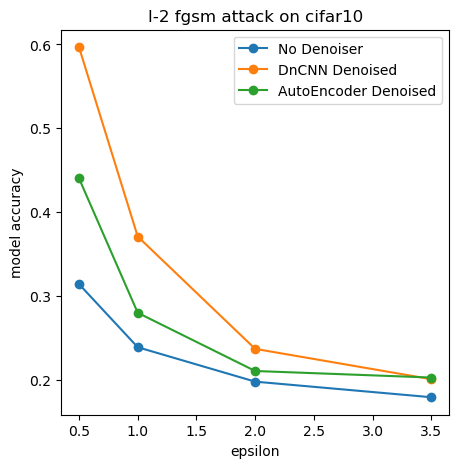

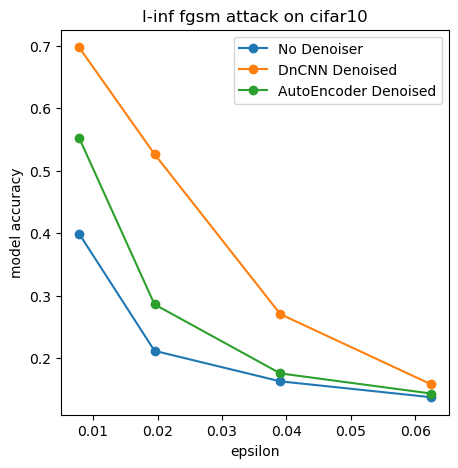

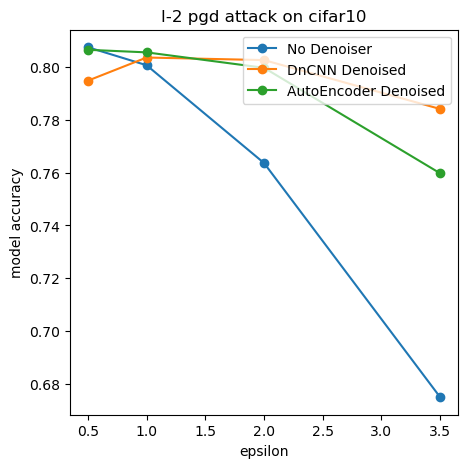

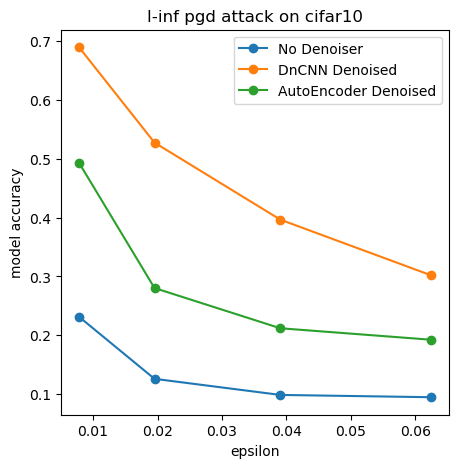

In [17]:
#plot cifar10
for attack in ['fgsm', 'pgd']:
    for norm in ['2', 'inf']:
        #print(f"\nEvaluating {attack} attack on l{norm} norm ...")
        file_path = os.path.join('denoiser_attack_results', f"cifar10_{attack}_l{norm}.pkl")
        result = load_result(file_path)
        plot_result(result, attack, norm, eps_range=l2_eps if (norm == '2') else linf_eps, dataset='cifar10', savefig=True)

In [ ]:
adv, denoised = run_test(cifar10_test_loader, cifar10_resnet, cifar10_dncnn_denoiser, 'fgsm', l2_eps, norm=2)
plt.plot(l2_eps, adv, marker='o')
plt.plot(l2_eps, denoised, marker='o')
plt.show()

In [ ]:
adv, denoised = run_test(mnist_test_loader, mnist_resnet, mnist_dncnn_denoiser, 'fgsm', linf_eps, norm=np.inf)
plt.plot(linf_eps, adv, marker='o')
plt.plot(linf_eps, denoised, marker='o')
plt.show()

In [ ]:
adv, denoised = run_test(cifar10_test_loader, cifar10_resnet, cifar10_dncnn_denoiser, 'fgsm', linf_eps, norm=np.inf)
plt.plot(linf_eps, adv, marker='o')
plt.plot(linf_eps, denoised, marker='o')
plt.show()

In [ ]:
import torch
x = torch.ones((4, 4)) / 2
y = torch.ones((2, 3, 4, 4))
yy = torch.randn_like(y[:, 0, :, :].unsqueeze(1))

#print(x)
z = x + y
print(z.size())
#print(z)
print(y.shape[-1])
print(y.shape[-2])
print(yy.shape)

In [ ]:
import torch
x = torch.tensor([-0.2, 0.3, 1.5])
print(torch.clamp(x, 0, 1))

In [ ]:
import numpy as np

a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
print(a-b)
print(np.sum(a-b))

In [ ]:
x = {'a': [1,2], 'b': 2}
y = {'a': [3,4], 'b': 4}
print(x)
x['a'] = y['a']
print(x)

In [ ]:
indices = torch.randperm(10000)[:1000]
print(indices.size())